# Week 4 - Evaluation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# !wget wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv')
data.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [4]:
data_new = data[['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders', 'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP']]
data_new.columns = data_new.columns.str.lower().str.replace(' ','_')
data_new.fillna(0, inplace=True)
price_avg = data_new.msrp.mean()
data_new['above_average'] = data_new['msrp'].apply(lambda x: int(x > price_avg))
data_new.drop(columns=['msrp'],inplace=True)
data_new.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,0


In [5]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(data_new, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

y_train = df_train['above_average'].values
y_val = df_val['above_average'].values

del df_train['above_average']
del df_val['above_average']
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_train.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg
0,Toyota,Highlander Hybrid,2016,280.0,6.0,AUTOMATIC,4dr SUV,28,27
1,Chevrolet,Impala Limited,2014,300.0,6.0,AUTOMATIC,Sedan,30,18
2,Buick,Regal,2016,259.0,4.0,AUTOMATIC,Sedan,27,19
3,Volkswagen,CC,2015,280.0,6.0,AUTOMATED_MANUAL,Sedan,25,17
4,Dodge,Grand Caravan,2016,283.0,6.0,AUTOMATIC,Passenger Minivan,25,17


# Which numerical variable (among the following 4) has the highest AUC?

In [6]:
from sklearn.metrics import auc, roc_auc_score
numerical_cols = ['engine_hp','engine_cylinders','highway_mpg','city_mpg']
roc_auc_scores = {}
for col in numerical_cols:
    roc_auc = roc_auc_score(y_train, df_train[col])
    if roc_auc < 0.5:
        roc_auc = roc_auc_score(y_train, -df_train[col])
    roc_auc_scores[col] = roc_auc
roc_auc_scores

{'engine_hp': 0.9171031265539011,
 'engine_cylinders': 0.766116490165669,
 'highway_mpg': 0.6330587871772013,
 'city_mpg': 0.6734244643245233}

We observe that `engine_hp` has the highest ROC AUC score.

In [7]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(df_train.to_dict(orient='records'))
X_val = dv.transform(df_val.to_dict(orient='records'))

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
y_pred = (model.predict_proba(X_val)[:, 1])
round(roc_auc_score(y_val, (y_pred >= 0.5).astype(int)), 3)

0.916

# What's the AUC of this model on the validation dataset? 

We observe that the closest is `0.979`.

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

thresholds = np.linspace(0, 1,101)
scores = []

for t in thresholds:
    precision = precision_score(y_val, (y_pred >= t).astype(int))
    recall = recall_score(y_val, y_pred >= t)
    scores.append((t, precision, recall))

columns = ['threshold', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)

In [9]:
intersect = df_scores.iloc[0:99]
intersect_point = np.argmin(np.abs(intersect['precision'] - intersect['recall']))

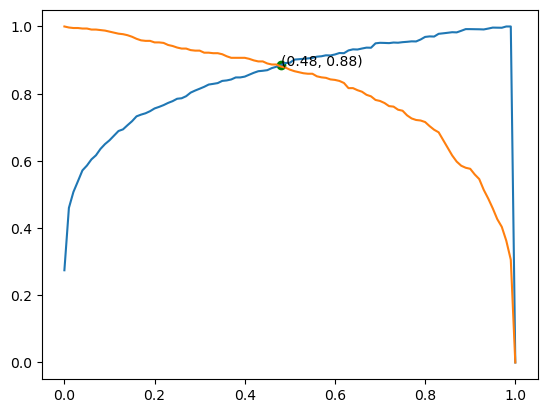

In [10]:
plt.plot(df_scores['threshold'], df_scores['precision'])
plt.plot(df_scores['threshold'], df_scores['recall'])
plt.scatter(df_scores.loc[intersect_point, 'threshold'], df_scores.loc[intersect_point, 'precision'], color='green')
plt.text(df_scores.loc[intersect_point, 'threshold'], df_scores.loc[intersect_point, 'precision'],
         f"({df_scores.loc[intersect_point, 'threshold']}, {df_scores.loc[intersect_point, 'precision']:.2f})")
plt.show()

# At which threshold precision and recall curves intersect?  

We observe that at `threshold=0.48` the precision and recall intersect.

In [11]:
df_scores['f1_score'] = (2 * df_scores['precision'] * df_scores['recall']) / (df_scores['precision'] + df_scores['recall'])
df_scores.loc[df_scores.f1_score.idxmax(), ['threshold','f1_score']]

threshold    0.490000
f1_score     0.884438
Name: 49, dtype: float64

In [12]:
df_scores.loc[df_scores.threshold.isin([0.12, 0.32, 0.52, 0.72]), ['threshold','f1_score']]

,threshold,f1_score
12,0.12,0.808591
32,0.32,0.872017
52,0.52,0.882812
72,0.72,0.846480


# At which threshold F1 is maximal?  

We observe that `0.52` is closest to 0.49 and hence has the maximum F1 score.

In [13]:
def train(df_train, y_train, c=1.0):
    dv = DictVectorizer(sparse=False)
    dicts = df_train.to_dict(orient='records')
    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

def predict(df, dv, model):
    dicts = df.to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred


In [19]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm 

kfold = KFold(n_splits=5, shuffle = True)

auc_scores = []
for train_idx, val_idx in kfold.split(df_full_train):
        # print(train_idx, val_idx)
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        X_train = df_train.drop(columns=['above_average'])
        X_val = df_val.drop(columns=['above_average'])
        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dv,model = train(df_train, y_train)
        y_pred = predict(df_val, dv, model)

        roc_auc = roc_auc_score(y_val, y_pred>0.5)
        auc_scores.append(roc_auc)
print(f"{np.mean(auc_scores).round(4)} +-{np.std(auc_scores).round(4)}")

0.9996 +-0.0005


# How large is standard devidation of the scores across different folds?

We observe that `0.003` is the closest so we choose as that as the answer.

In [21]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle = True)

c_score = {}
for c in tqdm([0.01, 0.1, 0.5, 10]):
    auc_scores = []
    for train_idx, val_idx in (kfold.split(df_full_train)):
        # print(train_idx, val_idx)
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        X_train = df_train.drop(columns=['above_average'])
        X_val = df_val.drop(columns=['above_average'])
        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dv,model = train(df_train, y_train, c)
        y_pred = predict(df_val, dv, model)

        roc_auc = roc_auc_score(y_val, y_pred >= 0.5)
        auc_scores.append(roc_auc)
    print(f"C:{c} => {np.mean(auc_scores):.3f}+-{np.std(auc_scores):.3f}")
    

  0%|          | 0/4 [00:00<?, ?it/s]

C:0.01 => 0.986+-0.003
C:0.1 => 0.999+-0.001
C:0.5 => 0.999+-0.000
C:10 => 0.999+-0.001


# Which C leads to the best mean score? 

We observe that `c=0.05` leads to best mean with minimum standard deviation.